In [1]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-success" style="font-size: 14px; border-radius: 10px"><h4>[GO] TO @ 2b738b4819f9d5f7e27ceef195fff2a0c807b592
</h4><pre>  ✅ No changes found in the ./TO packge.</pre></div>

# 0401 Centerpoints Point Order

**goal** 

idee om de symmterie van tenmiste individuele MMCs eruit te halen, levert dit iets op?

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, box

from dataclasses import replace
from typing import List
from tqdm import trange
from IPython.utils.io import capture_output

from TO import Topology
from TO.parameterizations.mmc import MMCAngularConfig, MMCCenterpointsConfig
from TO.parameterizations import Capsules
from TO.models import BinaryElasticMembraneModel
from TO.experiment import run_experiment
from TO.utils import get_fitness_values

In [ ]:
class CapsuleCenterpointOrder1(Capsules):
    def compute_geometry(self, x: np.ndarray) -> np.ndarray :
        x_configs = x.reshape(-1, len(self.normalization_factors))
        
        # alteration is the line below, adding all x1 terms to the x2 field to represent x2 as shift compared to x1 (inherent order)
        assert self.representation is MMCCenterpointsConfig, ''
        x_configs[:,2] += x_configs[:,0]

        mmcs: List[MMCAngularConfig] = [self.representation(*config).to_angular() for config in self.scale(x_configs)]

        if (self.symmetry_x) : # for all current configs mirror x-components
            raise NotImplemented('TODO : implement x-symmetry')
            mmcs += [replace(mmc, x=self.topology.domain_size_x-mmc.x) for mmc in mmcs] # TODO : update theta
        if (self.symmetry_y) : # for all currecnt configs mirror y-components, inlcuding ones just mirrored
            mmcs += [replace(mmc, y=self.topology.domain_size_y-mmc.y, theta=np.pi-mmc.theta) for mmc in mmcs]

        geo = MultiPolygon()
        for mmc in mmcs : # drawing and merging the polygons
            geo = geo.union(self.compute_polygon(mmc))
        return geo

In [ ]:
topology = Topology(
    continuous=True, 
    domain=box(0, 0, 100, 50), 
    density=1.0
)
# the parameterization we defined above
parameterization = CapsuleCenterpointOrder1(
    topology,
    representation=MMCCenterpointsConfig,
    symmetry_x=False, 
    symmetry_y=True, 
    n_components_x=3, 
    n_components_y=2, 
    n_samples=100,
)
model = BinaryElasticMembraneModel(
    topology, 
    thickness=1, 
    E11=25, 
    E22=1, 
    G12=0.5, 
    nu12=0.25, 
    Emin=1e-9
)

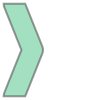

In [ ]:
x = np.zeros(parameterization.dimension).reshape(-1, 5)
#       x1, y1, x2, y2, r
x[0] = (.5, 0., .1, .5, .1)

parameterization.update_topology(topology, x)
topology.geometry

Note how even though $x_2<x_1$ the shape is still defined skewed to the right.

This is since we create an order among the points, i.e. point 2 is always to the right of point 1.

Note I could've also done this for $y$ instead, however $x$ comes first in the alphabet.

In [12]:
n_runs = 30
budget = 500

for seed in trange(n_runs):
    with capture_output():
        run_experiment(
            topology, parameterization, model,
            sigma0=0.25, budget=budget, seed=seed+1,
            name='pointorder'
        )

100%|██████████| 30/30 [28:01<00:00, 56.05s/it]


In [30]:
import pickle
with open('../0401_mmc_parameterizations/results.pkl', 'rb') as handle : experiments = pickle.load(handle)

pointorder
capsules


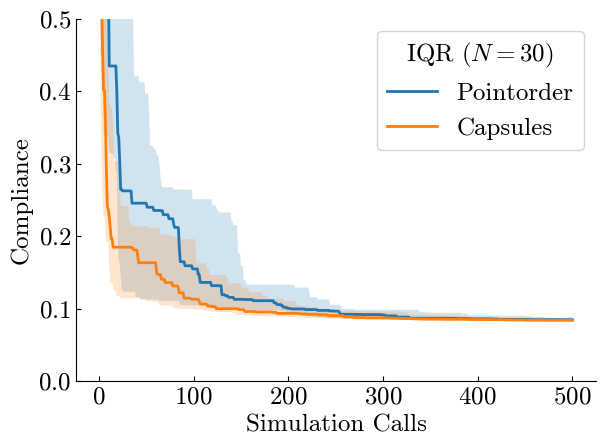

In [38]:
fig, ax = plt.subplots()

experiment_names = ('pointorder', 'capsules')
for exp in experiment_names:
    print(exp)
    if exp not in experiments:
        X = np.empty((n_runs, budget))
        for i in range(n_runs) :
            try:
                x = get_fitness_values(exp, i)
                X[i,:x.size] = np.minimum.accumulate(x)
                if (x.size < budget) :
                    print(f'[{i+1:03d}/{n_runs:03d}] converged before exceeded budget @ {x.size} with fitness {x.min()}')
                    X[i,x.size:] = x.min()
            except FileNotFoundError:
                print(f'[{i+1:03d}/{n_runs:03d}] converged before calling the simulation')
                X[i, :] = np.nan 
        experiments[exp] = X.copy()
    else :
        X = experiments[exp]
    X = X[~np.isnan(X).any(axis=1)]

    (Q2) = np.median(X, axis=0)
    (Q1, Q3) = np.percentile(X, [25, 75], axis=0)

    ax.plot(np.arange(budget)+1, Q2, lw=2, label=exp.capitalize())
    ax.fill_between(np.arange(budget)+1, Q1, Q3, alpha=.2)
ax.set_ylim(0, 0.5)

ax.legend(title=f'IQR ($N={len(experiments[exp])}$)');ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()

In [19]:
import pickle
with open('results.pkl', 'wb') as handle : pickle.dump(experiments, handle)

In [43]:
class CapsuleCenterpointOrder2(Capsules):
    def compute_geometry(self, x: np.ndarray) -> np.ndarray :
        x_configs = x.reshape(-1, len(self.normalization_factors))
        
        # alteration is the line below, adding all x1 terms to the x2 field to represent x2 as shift compared to x1 (inherent order)
        assert self.representation is MMCCenterpointsConfig, ''
        x_configs[:,2] = (1 - x_configs[:,0]) * x_configs[:,2] + x_configs[:,0]

        mmcs: List[MMCAngularConfig] = [self.representation(*config).to_angular() for config in self.scale(x_configs)]

        if (self.symmetry_x) : # for all current configs mirror x-components
            raise NotImplemented('TODO : implement x-symmetry')
            mmcs += [replace(mmc, x=self.topology.domain_size_x-mmc.x) for mmc in mmcs] # TODO : update theta
        if (self.symmetry_y) : # for all currecnt configs mirror y-components, inlcuding ones just mirrored
            mmcs += [replace(mmc, y=self.topology.domain_size_y-mmc.y, theta=np.pi-mmc.theta) for mmc in mmcs]

        geo = MultiPolygon()
        for mmc in mmcs : # drawing and merging the polygons
            geo = geo.union(self.compute_polygon(mmc))
        return geo

In [46]:
topology = Topology(
    continuous=True, 
    domain=box(0, 0, 100, 50), 
    density=1.0
)
# the parameterization we defined above
parameterization = CapsuleCenterpointOrder2(
    topology,
    representation=MMCCenterpointsConfig,
    symmetry_x=False, 
    symmetry_y=True, 
    n_components_x=3, 
    n_components_y=2, 
    n_samples=100,
)
model = BinaryElasticMembraneModel(
    topology, 
    thickness=1, 
    E11=25, 
    E22=1, 
    G12=0.5, 
    nu12=0.25, 
    Emin=1e-9
)

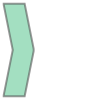

In [47]:
x = np.zeros(parameterization.dimension).reshape(-1, 5)
#       x1, y1, x2, y2, r
x[0] = (.5, 0., .1, .5, .1)

parameterization.update_topology(topology, x)
topology.geometry

In [48]:
n_runs = 30
budget = 500

for seed in trange(n_runs):
    with capture_output():
        run_experiment(
            topology, parameterization, model,
            sigma0=0.25, budget=budget, seed=seed+1,
            name='pointorder2'
        )

100%|██████████| 30/30 [28:33<00:00, 57.12s/it]


pointorder
pointorder2
capsules


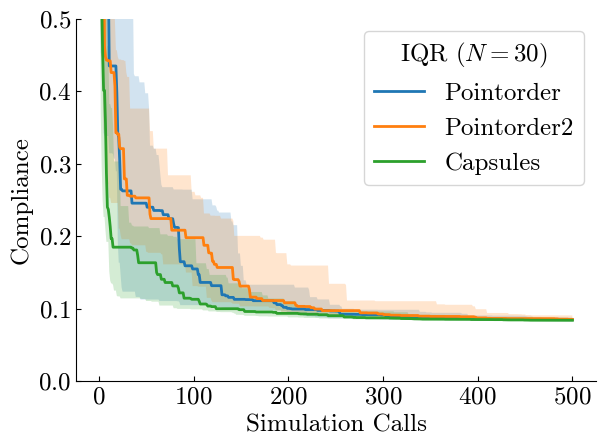

In [51]:
fig, ax = plt.subplots()

experiment_names = ('pointorder', 'pointorder2', 'capsules')
for exp in experiment_names:
    print(exp)
    if exp not in experiments:
        X = np.empty((n_runs, budget))
        for i in range(n_runs) :
            try:
                x = get_fitness_values(exp, i)
                X[i,:x.size] = np.minimum.accumulate(x)
                if (x.size < budget) :
                    print(f'[{i+1:03d}/{n_runs:03d}] converged before exceeded budget @ {x.size} with fitness {x.min()}')
                    X[i,x.size:] = x.min()
            except FileNotFoundError:
                print(f'[{i+1:03d}/{n_runs:03d}] converged before calling the simulation')
                X[i, :] = np.nan 
        experiments[exp] = X.copy()
    else :
        X = experiments[exp]
    X = X[~np.isnan(X).any(axis=1)]

    (Q2) = np.median(X, axis=0)
    (Q1, Q3) = np.percentile(X, [25, 75], axis=0)

    ax.plot(np.arange(budget)+1, Q2, lw=2, label=exp.capitalize())
    ax.fill_between(np.arange(budget)+1, Q1, Q3, alpha=.2)
ax.set_ylim(0, 0.5)

ax.legend(title=f'IQR ($N={len(experiments[exp])}$)');ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()